In [1]:
import os
import rdkit
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

from measures import *
from utils import fingerprint, similarities

RDKit WARNING: [14:05:06] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
MAX_STEP = 2000

def parse_mols_txt(file_name):
    data = []
    with open(file_name, 'r') as f:
        lines = f.readlines()
    
    step = None
    colums = []
    for line in lines:
        if line.startswith('molecules'):
            step = int(line.strip('\n').split(' ')[-1])
            if step > MAX_STEP: break
            continue
        if line.startswith('#'):
            columns = ['step'] + line.strip('\n').split('\t')
            continue
        data.append([step] + line.strip('\n').split('\t'))
    df = pd.DataFrame(data, columns=columns)
    return df

In [3]:
import pandas as pd

model_names = ['Baseline', 'AD', 'NN']

file_names = [
    'data/mols/mols_baseline.txt',
    'data/mols/mols_ad.txt',
    'data/mols/mols_nn.txt',
]

# dfs = []
df = pd.DataFrame()

for model, file_name in zip(model_names, file_names):
#     t = pd.read_csv(file_name, header=1, sep='\t')
    t = parse_mols_txt(file_name)
    for col in t.columns:
        if col == 'smiles': continue
        t[col] = pd.to_numeric(t[col], errors='coerce')
    t = t.dropna()
    t = t.drop_duplicates(subset='smiles')
    t['model'] = model
    df = df.append(t)

In [4]:
df['succ'] = \
    ((df['jnk3'] >= 0.5) & \
    (df['qed' ] >= 0.6) & \
    (df['sa'  ] >= .67)).tolist()
df['score'] = df['jnk3'] + df['qed'] + df['sa']
# df

In [5]:
df_succ = df[df['succ'] == True]
# df_succ

In [6]:
df_succ[df_succ['model'] == 'AD']

,step,#,score,jnk3,nov_nn,qed,sa,nov_ad,smiles,model,succ
39178,17,4475,2.145462,0.61,0.663158,0.668010,0.867452,0.934214,Clc1cc(Cl)cc(Nc2cc(-c3ccc4c(c3)OCO4)ccn2)c1,AD,True
49528,22,520,2.167089,0.63,0.693333,0.649782,0.887307,0.913803,COc1ccc(-c2ccnc(Nc3ccccc3Br)c2)c(OC)c1,AD,True
53907,23,4475,2.219917,0.59,0.602740,0.745773,0.884144,0.925410,Clc1cccc(Nc2cc(-c3ccc4c(c3)OCO4)ccn2)c1,AD,True
71590,31,1175,2.472717,0.82,0.671875,0.749926,0.902791,0.915286,Oc1ccccc1-c1ccnc(Nc2ccc(F)cc2)c1,AD,True
102529,44,657,2.270085,0.61,0.704225,0.797524,0.862561,0.918301,COc1ccc(-c2ccnc(Nc3cc(F)cc(F)c3)n2)cn1,AD,True
...,...,...,...,...,...,...,...,...,...,...,...
1594662,1700,3972,2.113139,0.59,0.571429,0.738711,0.784428,0.890639,N#Cc1nc(F)c(-c2ccnc(Nc3ccccn3)c2)c(C#N)n1,AD,True
1594667,1700,4288,1.863937,0.57,0.612903,0.615073,0.678864,0.896891,Fc1nc(F)c(-c2ccnc(NC3CC3NC3CCOCC3)c2)c(F)c1F,AD,True
1594670,1700,4463,2.152130,0.53,0.534247,0.841719,0.780411,0.897551,FNN1CCC(Nc2nccc(-c3cc(F)ccn3)n2)CC1,AD,True
1594672,1700,4613,2.038542,0.51,0.626374,0.716288,0.812254,0.890350,Cn1cc(Nc2c(F)cc(F)cc2F)c(-c2ccnc(NC3CC3)c2)n1,AD,True


In [41]:
def define_measures():
    measures = {
#         'GS' : GoldenStandard(),
#         'Diversity' : AvgAvgDis(),
#         'SumDiversity' : SumAvgDis(),
#         'Bottleneck' : MinMinDis(),
#         'SumBottleneck' : SumMinDis(),
#         'Diameter' : MaxMaxDis(),
#         'SumDiameter' : SumMaxDis(),
#         'DPP' : DPP(),
        '#FG' : NFragment(frag='FG'),
#         '#RS' : NFragment(frag='RS'),
#         '#Circles': NCirc(threshold=0.35),
    }
#     THRESHOLDS = [0.35] #np.linspace(0, 1, num=50)
#     for th in THRESHOLDS:
#         measures['N_Circ (c=%.2f)' % th] = NCirc(threshold=th)
    return measures

In [42]:
import random

measures = define_measures()
print(measures.keys())
columns = ['model', 'step', 'Richness'] + list(measures.keys())
measures_evaluated = []
data = []

for model in model_names:
    measures = define_measures()
    rich = 0
    for step in tqdm(range(MAX_STEP+1)):
        smiles = df_succ[(df_succ['model'] == model) & (df_succ['step'] == step)]['smiles']
        mols = [Chem.MolFromSmiles(smi) for smi in smiles]
        rich += len(smiles)
        entry = [model, step, rich]
        for name, measure in measures.items():
            if isinstance(measure, DissimilarityBasedMeasure):
                mols_ = [mol for mol in mols if random.random() < 0.05]
            else: mols_ = mols
            measure.update(mols_)
            entry.append(measure.report())
        data.append(entry)
    measures_evaluated.append(measures)
        
df_curve = pd.DataFrame(data=data, columns=columns)
# df_curve

dict_keys(['#FG'])


100%|██████████| 1701/1701 [06:03<00:00,  4.68it/s]


In [37]:
df_curve[df_curve['model'] == 'Baseline']

,model,step,Richness,Diversity
0,Baseline,0,0,0.000000
1,Baseline,1,0,0.000000
2,Baseline,2,0,0.000000
3,Baseline,3,0,0.000000
4,Baseline,4,0,0.000000
...,...,...,...,...
1696,Baseline,1696,124073,0.737169
1697,Baseline,1697,124104,0.737213
1698,Baseline,1698,124127,0.737220
1699,Baseline,1699,124151,0.737240


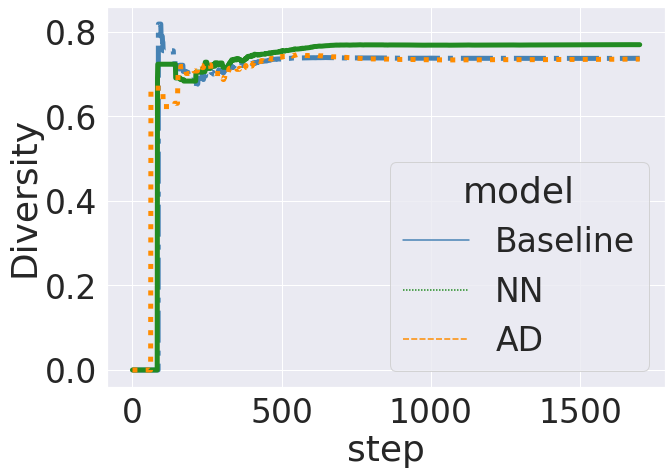

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr

measure_name = 'Diversity'

plt.figure(figsize=(10, 7))
sns.set(font_scale=3)
ax = sns.lineplot(data=df_curve, x='step', y=measure_name, hue='model', style='model', linewidth=5, legend=True,
             hue_order=['Baseline', 'NN', 'AD'], 
             palette=['steelblue', 'forestgreen', 'darkorange'])
ax.lines[0].set_linestyle("dashdot")
ax.lines[1].set_linestyle("solid")
ax.lines[2].set_linestyle("dotted")
# ax.set_ylabel(ax.get_ylabel(), rotation=90)
# ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{int(y/1000)}K'))

In [43]:
def fingerprint(mol):
    try: 
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    except:
        fp = np.zeros(1024)
    return fp

labels = []
fps = []
for name, measures in zip(model_names, measures_evaluated):
    measure = measures['#FG']
    smiles = measure.df['frags'].tolist()
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    fps += [fingerprint(mol) for mol in mols]
    labels += [name] * len(smiles)
nfps = np.array(fps)
nfps

RDKit ERROR: [15:41:34] non-ring atom 0 marked aromatic
RDKit ERROR: [15:41:34] non-ring atom 0 marked aromatic
RDKit ERROR: [15:41:34] non-ring atom 0 marked aromatic
RDKit ERROR: [15:41:34] non-ring atom 0 marked aromatic
RDKit ERROR: [15:41:34] non-ring atom 0 marked aromatic
RDKit ERROR: [15:41:34] non-ring atom 0 marked aromatic
RDKit ERROR: [15:41:34] non-ring atom 0 marked aromatic
RDKit ERROR: [15:41:34] non-ring atom 0 marked aromatic
RDKit ERROR: [15:41:34] non-ring atom 0 marked aromatic
RDKit ERROR: [15:41:34] non-ring atom 0 marked aromatic
RDKit ERROR: [15:41:34] non-ring atom 0 marked aromatic
RDKit ERROR: [15:41:34] non-ring atom 0 marked aromatic
RDKit ERROR: [15:41:34] non-ring atom 0 marked aromatic
RDKit ERROR: [15:41:34] non-ring atom 0 marked aromatic
RDKit ERROR: [15:41:34] non-ring atom 0 marked aromatic
RDKit ERROR: [15:41:34] non-ring atom 0 marked aromatic
RDKit ERROR: [15:41:34] non-ring atom 0 marked aromatic
RDKit ERROR: [15:41:34] non-ring atom 0 marked a

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [124]:
import umap
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD, PCA, KernelPCA
from sklearn.manifold import TSNE, MDS

COLORS = ['steelblue', 'darkorange', 'forestgreen']

# mapper = umap.UMAP(metric='jaccard', n_neighbors=30, min_dist=0.99)
mapper = PCA(n_components=2)
# mapper = TruncatedSVD(n_components=2)
# mapper = TSNE(n_components=2, perplexity=50)
X = mapper.fit_transform(nfps)

[[Text(0, -2.0, ''),
  Text(0, -1.5, ''),
  Text(0, -1.0, ''),
  Text(0, -0.5, ''),
  Text(0, 0.0, ''),
  Text(0, 0.5, ''),
  Text(0, 1.0, ''),
  Text(0, 1.5, ''),
  Text(0, 2.0, '')]]

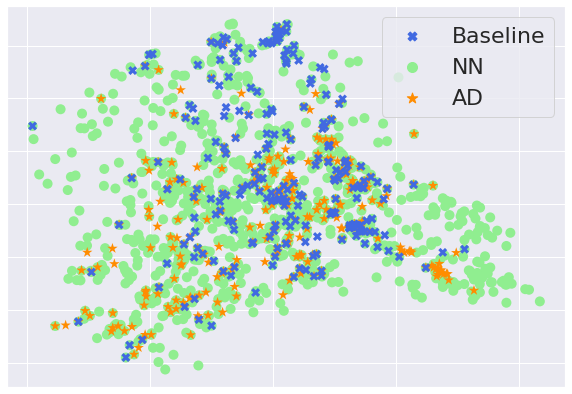

In [126]:
plt.figure(figsize=(10, 7))
sns.set(font_scale=2)
ax = sns.scatterplot(x=X[::-1,0], y=X[::-1,1], linewidth=0, #alpha=0.8,
                hue=labels[::-1], style=labels[::-1], size=labels[::-1],
                hue_order=['Baseline', 'NN', 'AD'], 
#                 palette=['steelblue', 'forestgreen', 'darkorange'],
                palette=['royalblue', 'lightgreen', 'darkorange'],
                markers={'Baseline' : 'X', 'AD' : '*', 'NN' : 'o'},
                sizes={'Baseline' : 80, 'AD' : 120, 'NN' : 100})
ax.set(xticklabels=[])
ax.set(yticklabels=[])
# plt.scatter()
# plt.show()

In [ ]:
df_succ

In [ ]:
smiles = df_succ[df_succ['model'] == 'AD']['smiles'].tolist()
smiles = random.choices(smiles, k=1000)
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
fps = [fingerprint(mol) for mol in mols]

In [ ]:
import numpy as np

sim = [similarities(fp, fps) for fp in fps]
sim = np.array(sim)
sim

In [ ]:
g = sns.clustermap(sim)
ax = g.ax_heatmap
ax.set(xticklabels=[])
ax.set(yticklabels=[])